# B3情報科学演習：時系列データ分析（後編）

---

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from tqdm.notebook import tqdm
from datetime import timedelta
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim import lr_scheduler

In [54]:
# import warnings
# warnings.filterwarnings('ignore')

## データ読み込み

./tutorial_data.ipynbで作成したデータを使う  

In [2]:
data = pd.read_csv('./data/processed_data.csv', index_col=['datetime'], parse_dates=['datetime'])
test_data = pd.read_csv('./data/processed_test_data.csv', index_col=['datetime'], parse_dates=['datetime'])
data.head()


,PM25,PM10,SO2,NO2,CO,O3,temp,pres,dewp,prec,wind_dire,wd,hour,woy,temp_diff
datetime,,,,,,,,,,,,,,,
2013-03-01 00:00:00,3.0,6.0,3.0,8.0,300.0,44.0,-0.9,1025.8,-20.5,0.0,NW,9.3,0,9,NaN
2013-03-01 01:00:00,12.0,12.0,3.0,7.0,300.0,47.0,-1.1,1026.1,-21.3,0.0,NW,9.4,1,9,-0.2
2013-03-01 02:00:00,14.0,14.0,NaN,7.0,200.0,22.0,-1.7,1026.2,-23.0,0.0,NW,8.6,2,9,-0.6
2013-03-01 03:00:00,12.0,12.0,3.0,5.0,NaN,NaN,-2.1,1027.3,-23.3,0.0,NW,6.6,3,9,-0.4
2013-03-01 04:00:00,12.0,12.0,3.0,NaN,200.0,11.0,-2.4,1027.7,-22.9,0.0,NW,4.5,4,9,-0.3


---

## Random Forest

Random Forestは決定木ベースのアンサンブル（バギング）モデル  
決定木ベースなので完全な連続値の表現はできないが，複数の決定木により可能になる

### 前処理、FE

ここで紹介する前処理は訓練データとテストデータで処理が変わる前処理  
考え方としては，訓練データのみで何らかの計算をして，その計算で得た情報をテストデータにも適用する，といった感じで2段階に分けて処理を行う  

#### 離散値（文字列）の数値変換

風向（wind_dire）は離散値であり文字列を含むため，数値を入力とする学習モデルにそのまま入力することはできない  
離散値を数値に変換する方法も沢山あるが，今回はラベルエンコーダーを適用する  
ラベルエンコーダーは文字列と数値を1対1対応させて変換する  

In [56]:
le = LabelEncoder()

tmp = pd.DataFrame(data['wind_dire'].copy())
tmp2 = pd.DataFrame(test_data['wind_dire'].copy())
tmp['wind_dire_label'] = le.fit_transform(data['wind_dire'])
tmp2['wind_dire_label'] = le.fit_transform(test_data['wind_dire'])
tmp.head(10)

,wind_dire,wind_dire_label
datetime,,
2013-03-01 00:00:00,NW,7
2013-03-01 01:00:00,NW,7
2013-03-01 02:00:00,NW,7
2013-03-01 03:00:00,NW,7
2013-03-01 04:00:00,NW,7
2013-03-01 05:00:00,NNW,6
2013-03-01 06:00:00,NNE,5
2013-03-01 07:00:00,NE,4
2013-03-01 08:00:00,NNW,6


ラベルエンコーダーは訓練データとテストデータを一括して処理しても一見よさそうに見えるが，  
場合によってはテストデータにのみ発生する文字列があるかもしれない  
その場合は，識別できない文字列という括りでのラベルの割り当てが適切になる

ちなみに，決定木ベースでない場合はラベルエンコーダーはおすすめしない  
ラベルエンコーダーでは0,1,2...と数値が割り振られるが，数値の大小関係の意味合いは持たない  
しかし，学習器によってはそれをそのまま数値として学習するため，意図せず大小関係を学習しようとして予測性能が落ちる可能性がある

#### クラスタリング

データをクラスタリングした結果を特徴量にしちゃう（藤浪「自分はやったことない」佐藤「自分もない」）  
データは連続値だけど細かい変動より大まかな値にしか興味がない場合に有効かな？  
訓練データでクラスタ境界を計算し，その境界を基にテストデータもクラスタリング

temp, humi, presのクラスタリング結果を特徴量に追加

In [57]:
km = KMeans(n_clusters=10, random_state=0)
tmp = data[['temp', 'dewp', 'pres']].dropna(how='any').copy()
tmp['cluster'] = km.fit_predict(tmp)

tmp2 = test_data[['temp', 'dewp', 'pres']].dropna(how='any').copy()
tmp2['cluster'] = km.fit_predict(tmp2)

tmp
tmp2

,temp,dewp,pres,cluster
datetime,,,,
2016-03-01 00:00:00,-0.3,-13.9,1024.8,2
2016-03-01 01:00:00,-0.1,-13.4,1024.8,2
2016-03-01 02:00:00,-0.6,-13.2,1024.0,2
2016-03-01 03:00:00,-1.8,-11.1,1023.6,2
2016-03-01 04:00:00,-2.4,-10.0,1023.3,2
...,...,...,...,...
2017-02-28 19:00:00,10.3,-12.4,1014.2,4
2017-02-28 20:00:00,9.8,-9.9,1014.5,4
2017-02-28 21:00:00,9.1,-12.7,1014.6,4


#### 欠損値の処理

今回は連続値には線形補間，離散値にはffill（前回の値を代入）を適用する  
ただし訓練データのみ  
テストデータは除去する

補間前

In [58]:
data['PM25'].iloc[1165:1174]

datetime
2013-04-18 13:00:00     7.0
2013-04-18 14:00:00     NaN
2013-04-18 15:00:00     9.0
2013-04-18 16:00:00    10.0
2013-04-18 17:00:00     7.0
2013-04-18 18:00:00     7.0
2013-04-18 19:00:00     8.0
2013-04-18 20:00:00    14.0
2013-04-18 21:00:00    12.0
Name: PM25, dtype: float64

補間後

In [59]:
data['PM25'].interpolate(inplace=True)

In [60]:
data['PM25'].iloc[1165:1174]

datetime
2013-04-18 13:00:00     7.0
2013-04-18 14:00:00     8.0
2013-04-18 15:00:00     9.0
2013-04-18 16:00:00    10.0
2013-04-18 17:00:00     7.0
2013-04-18 18:00:00     7.0
2013-04-18 19:00:00     8.0
2013-04-18 20:00:00    14.0
2013-04-18 21:00:00    12.0
Name: PM25, dtype: float64

### モデル学習の準備

訓練・検証・テストにデータ分割をした後，前処理・FEを行い，学習を繰り返してパラメータチューニングを行う

#### ハイパーパラメータのチューニング

基本的にどんな学習器でも手動で決定するパラメータ（ハイパーパラメータ）が存在する  
訓練・検証データを使って交差検証の結果から適したハイパーパラメータを見つける  
チューニングもやり方が色々あるが，一番単純だが採用されることも多いグリッドサーチを使う  

藤浪「scikit-learnにはGridSearchCVという便利な関数があるが使い慣れてないので自分で実装する（本当は使っていった方がいい）」

In [61]:
# パラメータ候補（適当に3つ）
params = {
    'n_estimators':[10,50,100],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[3,5,None]
}

In [62]:
test_data


,SO2,NO2,CO,O3,temp,pres,dewp,prec,wind_dire,wd
datetime,,,,,,,,,,
2016-03-01 00:00:00,29.0,84.0,1600.0,3.0,-0.3,1024.8,-13.9,0.0,ESE,0.7
2016-03-01 01:00:00,36.0,80.0,2000.0,3.0,-0.1,1024.8,-13.4,0.0,ENE,1.5
2016-03-01 02:00:00,29.0,74.0,2000.0,2.0,-0.6,1024.0,-13.2,0.0,SE,1.2
2016-03-01 03:00:00,28.0,72.0,2200.0,2.0,-1.8,1023.6,-11.1,0.0,NE,0.7
2016-03-01 04:00:00,21.0,72.0,2200.0,2.0,-2.4,1023.3,-10.0,0.0,NNE,1.1
...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,8.0,92.0,800.0,16.0,10.3,1014.2,-12.4,0.0,W,1.8
2017-02-28 20:00:00,17.0,86.0,1100.0,19.0,9.8,1014.5,-9.9,0.0,NW,1.5
2017-02-28 21:00:00,4.0,30.0,500.0,64.0,9.1,1014.6,-12.7,0.0,NE,1.7


#### 前処理の関数

前節で書いたFE・前処理を一つの関数にまとめる  
藤浪「これもscikit-learnにはpipelineという簡単に前処理をカスタマイズして適用するモジュールがあるが，使い慣れてないので使わない」

In [63]:
def preprocessing(train, test):
    test.dropna(how='any', inplace=True)    # テストデータは補完せずに全部除去

    # 離散値
    train['wind_dire'] = train['wind_dire'].fillna(method='ffill')  # 欠損値

    le = LabelEncoder() # ラベルエンコーダー
    train['wind_dire'] = le.fit_transform(train['wind_dire'])
    test['wind_dire'] = le.transform(test['wind_dire'])
    
    # 連続値
    tmp = train.drop('wind_dire', axis=1).interpolate().copy()  # 欠損値
    tmp['wind_dire'] = train['wind_dire']
    train = tmp.copy()
    train.dropna(how='any', inplace=True)   # temp_diffが必ず欠損値残るため除去
    
    km = KMeans(n_clusters=10, random_state=0)  # クラスタリング特徴量
    train['cluster'] = km.fit_predict(train[['temp', 'dewp', 'pres']])
    test['cluster'] = km.predict(test[['temp', 'dewp', 'pres']])

    # カラムの順番ずれるため統一する
    test = test[train.columns].copy()
    return train, test

### モデル学習・検証

とりあえずパーツは整ったので後は検証を行っていくのみ  
各ハイパーパラメータの組み合わせに対して3-交差検証の予測スコアの平均を出す  
当然だがここではテストデータは全く使用しない．使っていたらそれは不正．テストデータは学習段階では存在しない扱いであることを忘れずに

検証を早く終わらせるコツとして，データ分割のイテレート⇒パラメータのイテレートの順で行うと，データ分割に要する時間を節約できる

In [64]:
def get_score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mae, rmse

In [65]:
target_name = 'PM25'
result_list = []

# パラメータdictのリスト作成
args, values = zip(*params.items())
params_list = [dict(zip(args, p)) for p in product(*values)]

# データ分割
trainval_data = data.copy()   # 訓練・検証
tscv = TimeSeriesSplit(n_splits=6)
for i, (train_index, val_index) in tqdm(enumerate(tscv.split(trainval_data))):
    if i < 3:
        continue
    train_data, val_data = data.iloc[train_index].copy(), data.iloc[val_index].copy() # 訓練/検証
    train_data, val_data = preprocessing(train_data, val_data)

    X_train, y_train = train_data.drop([target_name, "PM10"], axis=1), train_data[target_name]
    X_val, y_val = val_data.drop([target_name,"PM10"], axis=1),  val_data[target_name]

    for p in tqdm(params_list):   # パラメータ
        p['random_state'] = 0
        rf = RandomForestRegressor(**p)
        rf.fit(X_train, y_train)
        pred_train = rf.predict(X_train)
        pred_val = rf.predict(X_val)
        df_res = pd.DataFrame(data=p.values(), index=p.keys()).T
        df_res[['r2_train', 'mae_train', 'rmse_train']] = get_score(y_train, pred_train)
        df_res[['r2_val', 'mae_val', 'rmse_val']] = get_score(y_val, pred_val)
        result_list.append(df_res)
df_result = pd.concat(result_list, axis=0)
df_result.fillna('None', inplace=True)
df_result = df_result.groupby(['n_estimators', 'max_features', 'max_depth', 'random_state']).mean()
df_result.reset_index(inplace=True)
df_result.to_csv('./result/rf_validation.csv', index=False)

0it [00:00, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

  0%|          | 0/27 [00:00<?, ?it/s]

c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

  0%|          | 0/27 [00:00<?, ?it/s]

c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

結果一覧表

In [66]:
df_result = pd.read_csv('./result/rf_validation.csv')
df_result

,n_estimators,max_features,max_depth,random_state,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
0,10,auto,3,0,0.604394,33.016160,47.933424,0.612340,29.959614,46.748819
1,10,auto,5,0,0.691120,28.621153,42.352907,0.655004,27.069494,43.687299
2,10,auto,None,0,0.974376,7.107475,12.196372,0.664919,25.328260,42.638670
3,10,log2,3,0,0.500711,38.857736,53.847437,0.469308,38.861792,56.802608
4,10,log2,5,0,0.636721,32.079719,45.923939,0.585125,31.397161,49.912829
5,10,log2,None,0,0.969094,8.050757,13.397452,0.670140,26.207987,43.395039
6,10,sqrt,3,0,0.500711,38.857736,53.847437,0.469308,38.861792,56.802608
7,10,sqrt,5,0,0.636721,32.079719,45.923939,0.585125,31.397161,49.912829
8,10,sqrt,None,0,0.969094,8.050757,13.397452,0.670140,26.207987,43.395039
9,50,auto,3,0,0.605420,32.987830,47.869141,0.610445,30.082763,46.867786


訓練データへの精度と検証データへの精度を見て，正しく学習が行われてそうか確認する  
藤浪「なんかまったくmax_featuresの'log2'と'sqrt'の結果が一緒だけど気にしない！（log2(14)≒3.80と√14≒3.74で整数にしたら同じなため）」  
佐藤「複数のパラメータで同一の結果が得られるのであれば，時間節約のためにもどちらかを採用し，他のパラメータを試した方が良い」

検証データの精度が高い組み合わせが汎化性能が高いといえるので，検証データの精度が良い部分を抽出する

In [67]:
df_result[(df_result['r2_val'] == df_result['r2_val'].max()) | (df_result['mae_val'] == df_result['mae_val'].min()) | (df_result['rmse_val'] == df_result['rmse_val'].min())]

,n_estimators,max_features,max_depth,random_state,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
20,100,auto,None,0,0.983492,6.049560,9.791017,0.687920,24.222694,40.992375
23,100,log2,None,0,0.981561,6.594783,10.347322,0.706352,24.309997,40.933592
26,100,sqrt,None,0,0.981561,6.594783,10.347322,0.706352,24.309997,40.933592


過学習してて検証データの精度も悪いが，とりあえずこの2モデルが3つの評価指標（R^2, MAE, RMSE）において優秀だった  
上述したように'log2'と'sqrt'は同じなので実質1モデルのみ  
おまけに，このモデルとmax_features='auto'にしたモデルとをバギングしたアンサンブルモデルも後で試してみる

### モデル評価

モデル学習で適したパラメータを選択できたということで，最後にテストデータを使ってモデルの評価を行う  
検証データも既に持っているデータという意味で訓練データの一種なので，訓練・検証データで学習を行い，テストデータで評価を行う  
ただし，実際のパラメータチューニングの検証は訓練データのみで学習しているため，無理に混ぜる必要性もない

In [68]:
from IPython.display import display
target_name = 'PM25'
result_list_eval = []
pred_list = []  # 後でバギングするために保存

# データ分割
trainval_data = data.copy()   # 訓練・検証
tscv = TimeSeriesSplit(n_splits=6)
for i, (train_index, val_index) in tqdm(enumerate(tscv.split(trainval_data))):
    if i < 3:
        continue
    train_data, val_data = data.iloc[train_index].copy(), data.iloc[val_index].copy() # 訓練/検証
    train_data, val_data = preprocessing(train_data, val_data)

    X_train, y_train = train_data.drop([target_name,"PM10"], axis=1), train_data[target_name]
    X_val, y_val = val_data.drop([target_name,"PM10"], axis=1), val_data[target_name]

    xtrain_df = pd.DataFrame(X_val)
    display(xtrain_df)

0it [00:00, ?it/s]

,SO2,NO2,CO,O3,temp,pres,dewp,prec,wd,hour,woy,temp_diff,wind_dire,cluster
datetime,,,,,,,,,,,,,,
2014-11-17 09:00:00,10.0,31.0,1700.0,35.0,5.7,1013.0,-8.2,0.0,1.6,9,47,2.4,5,1
2014-11-17 12:00:00,6.0,21.0,1500.0,57.0,10.5,1014.0,-12.2,0.0,3.1,12,47,1.1,7,1
2014-11-17 15:00:00,7.0,20.0,200.0,66.0,12.9,1013.0,-13.2,0.0,3.2,15,47,0.5,14,1
2014-11-17 16:00:00,7.0,27.0,300.0,60.0,12.2,1013.0,-12.9,0.0,2.0,16,47,-0.7,14,1
2014-11-17 17:00:00,8.0,37.0,300.0,49.0,9.6,1014.0,-10.6,0.0,0.7,17,47,-2.6,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-22 17:00:00,5.0,23.0,400.0,139.0,25.3,1010.2,-0.7,0.0,4.6,17,17,-0.9,11,5
2015-04-22 18:00:00,5.0,26.0,400.0,130.0,24.3,1009.8,-0.1,0.0,4.5,18,17,-1.0,8,5
2015-04-22 19:00:00,9.0,35.0,400.0,126.0,23.0,1009.9,0.7,0.0,3.4,19,17,-1.3,11,5


,SO2,NO2,CO,O3,temp,pres,dewp,prec,wd,hour,woy,temp_diff,wind_dire,cluster
datetime,,,,,,,,,,,,,,
2015-04-22 22:00:00,12.0,39.0,500.0,86.0,21.3,1010.4,2.5,0.0,3.1,22,17,-0.3,8,3
2015-04-22 23:00:00,12.0,47.0,500.0,69.0,19.6,1010.2,2.9,0.0,2.4,23,17,-1.7,10,3
2015-04-23 00:00:00,13.0,50.0,500.0,58.0,18.3,1009.8,3.3,0.0,2.5,0,17,-1.3,10,3
2015-04-23 01:00:00,11.0,41.0,500.0,43.0,17.1,1009.6,3.7,0.0,0.6,1,17,-1.2,10,3
2015-04-23 02:00:00,17.0,37.0,400.0,11.0,15.3,1009.3,4.9,0.0,1.1,2,17,-1.8,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-26 06:00:00,2.0,29.0,300.0,7.0,11.7,1010.9,7.0,0.0,1.5,6,39,-0.2,3,2
2015-09-26 07:00:00,2.0,35.0,200.0,2.0,12.0,1011.4,7.1,0.0,2.0,7,39,0.3,3,2
2015-09-26 08:00:00,2.0,24.0,200.0,11.0,14.1,1011.8,7.6,0.0,1.8,8,39,2.1,3,2


KeyboardInterrupt: 

In [70]:
# モデル定義
best_model = RandomForestRegressor(n_estimators=100, max_features='auto', max_depth=None)   # 最強モデル
zako_model = RandomForestRegressor(n_estimators=50, max_features='log2', max_depth=3)
rf_dict = {'best':best_model, 'zako':zako_model}

target_name = 'PM25'
result_list_eval = []
pred_list = []  # 後でバギングするために保存

# データ分割
trainval_data = data.copy()   # 訓練・検証
tscv = TimeSeriesSplit(n_splits=6)
for i, (train_index, val_index) in tqdm(enumerate(tscv.split(trainval_data))):
    if i < 3:
        continue
    train_data, val_data = data.iloc[train_index].copy(), data.iloc[val_index].copy() # 訓練/検証
    train_data, val_data = preprocessing(train_data, val_data)

    X_train, y_train = train_data.drop([target_name,"PM10"], axis=1), train_data[target_name]
    X_val, y_val = val_data.drop([target_name,"PM10"], axis=1), val_data[target_name]


    for name, rf in rf_dict.items():
        rf.fit(X_train, y_train)
        pred_train = rf.predict(X_train)
        pred_test = rf.predict(X_val)
        df_res = pd.DataFrame(index=[f'{name}'])
        df_res[['r2_train', 'mae_train', 'rmse_train']] = get_score(y_train, pred_train)
        df_res[['r2_val', 'mae_val', 'rmse_val']] = get_score(y_val, pred_test)
        result_list_eval.append(df_res)
        pred_list.append((pred_train, pred_val))
df_result = pd.concat(result_list_eval, axis=0)
df_result.to_csv('./result/rf_eval.csv', index=True)

0it [00:00, ?it/s]

c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

In [38]:
#デフォルト
# モデル定義
best_model = RandomForestRegressor(n_estimators=100, max_features='auto', max_depth=None)   # 最強モデル
zako_model = RandomForestRegressor(n_estimators=50, max_features='log2', max_depth=3)
rf_dict = {'best':best_model, 'zako':zako_model}

target_name = 'PM25'
result_list_eval = []
pred_list = []  # 後でバギングするために保存

# データ分割
train_data = data.copy()   # 訓練・検証/テスト
train_data, test_data = preprocessing(train_data, test_data)

X_train, y_train = train_data.drop(target_name, axis=1), train_data[target_name]
X_test, y_test = test_data.drop(target_name, axis=1), test_data[target_name]

for name, rf in rf_dict.items():
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    pred_test = rf.predict(X_test)
    df_res = pd.DataFrame(index=[f'{name}'])
    df_res[['r2_train', 'mae_train', 'rmse_train']] = get_score(y_train, pred_train)
    df_res[['r2_test', 'mae_test', 'rmse_test']] = get_score(y_test, pred_test)
    result_list_eval.append(df_res)
    pred_list.append((pred_train, pred_test))
df_result = pd.concat(result_list_eval, axis=0)
df_result.to_csv('./result/rf_eval.csv', index=True)

c:\Users\large\anaconda3\envs\first_GPU\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


NameError: name 'X_test' is not defined

結果一覧表

In [52]:
df_result = pd.read_csv('./result/rf_eval.csv', index_col=[0])
df_result

,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
best,0.983242,6.111288,9.905545,0.775752,23.967317,39.370136
zako,0.525347,38.143336,52.716881,0.614716,33.842556,51.605097
best,0.983919,6.080670,9.871877,0.490062,21.807837,34.344653
zako,0.536748,37.656313,52.984816,0.364696,31.424463,38.334631
best,0.983571,5.946024,9.520752,0.792371,27.059104,49.062843
zako,0.522967,36.090732,51.301934,0.462321,46.102600,78.953318


検証データよりも精度が高くなった  
これの要因としてはまず訓練・検証データ全部で学習したことにより学習データが増えたこと  
もう一つさらに大きな要因として，TimeSeriesSplitを使っていることが考えられる  
時間をずらすことによってデータ数や分布に差が生まれるため，交差検証毎に精度が大きく変わりやすく，平均したときに精度が低く見える

#### アンサンブルモデル（バギング）

おまけとして2つのRandom Forestをバギングして評価指標を見てみたいと思う  
バギングは単純に2モデルの予測値の平均を取るだけ

In [71]:
pred_train_list = np.array([p[0] for p in pred_list])
pred_val_list = np.array([p[1] for p in pred_list])

pred_train_bagg = pred_train_list.mean(axis=0)
pred_val_bagg = pred_val_list.mean(axis=0)

df_res = pd.DataFrame(index=['bagging'])
df_res[['r2_train', 'mae_train', 'rmse_train']] = get_score(y_train, pred_train_bagg)
df_res[['r2_val', 'mae_val', 'rmse_val']] = get_score(y_val, pred_val_bagg)
df_res

C:\Users\large\AppData\Local\Temp\ipykernel_24192\4241959985.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_train_list = np.array([p[0] for p in pred_list])


ValueError: operands could not be broadcast together with shapes (15032,) (18789,) 

あまり変わっていない…？けど悪くはなってない  
今回は全評価指標において1つのモデルが最良と出たが，複数あってどれ選べばいいか分からない！という場合もある  
そういう場合はとりあえずバギングしてみるとこんな感じでそこそこの結果を得られるかも（テストデータの結果を見てから選ぶのは不正）  
バギングは各モデルの誤差のばらつき（バリアンス）を平均化して低減することが目的であるため，Random Forest以外の誤差に異なる傾向を持ちそうなモデルとするのがいいかもしれない

#### 特徴量重要度（おまけ）

Random Forestを使用した特徴量重要度を見てみる  
決定木ベースのモデル（scikit-learn）は基本的に重要度が見れるようになっている  
どうやって重要度を求めてるのかは知らないので割愛  

実際には検証データに対して重要度を見て，不要な特徴量を除去するなど対処を行う  
テストデータで見るのは自由だが，その結果から特徴量エンジニアリング等をするのは不正

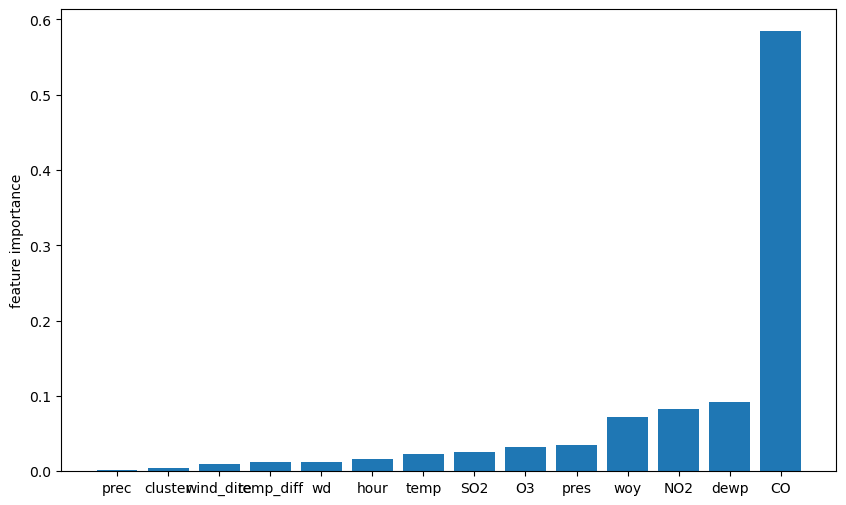

In [73]:
sr_imp = pd.Series(index=X_train.columns, data=best_model.feature_importances_)
sr_imp.sort_values(inplace=True)
plt.figure(figsize=[10,6])
plt.ylabel('feature importance')
plt.bar(sr_imp.index, sr_imp)
plt.savefig("image/juuyoudo.png")

結果を見るとprec, ac_precが低いことから降水量はほとんど関係ないことが分かる  
なのでこの特徴量は不要であった可能性が高い

最も重要度が高いのは年始からの経過週数（woy）で次いで湿度（humi），露点（dewp），気圧（pres），気温（temp）と環境データが続いてる  
前述したが，時間を表す特徴量は予測することだけに着目した場合優秀な特徴量といえるが，あくまで人間が定めた指標であるため因果関係なんてものはない（疑似相関に該当すると思う）  
環境データからPM2.5を予測したいというのが目的であったのに，結果がこれでは手段が間違っていると言われる可能性もある  

特徴量重要度の信頼性はそのモデルの精度に比例すると思う  
訓練データに対する精度は高いが，テストデータに対しては低いので，汎化性を持つ結果であるかは微妙

---

## LSTM

LSTM（Long Short Term Memory）はニューラルネットワークの一種で時系列データの学習を得意とするモデル  
RNNと呼ばれるニューラルネットワークの一種でもあるが，RNNよりも長い時系列に対応するように設計されている  

### 前処理、FE

#### 離散値（文字列）の数値変換

Random Forestの時と違ってラベルエンコーダーは使わない  
決定木ベースの手法では数値の大小関係を見ないため使ってもよかった（実際は大小関係を見ているが複数の条件分岐でどうとでもなる）  
LSTMはy=ax+bのような回帰式を用いるため、大小関係に気を付ける必要がある  

代わりにワンホットエンコーダーを使って数値化する  
2値で表現された新しい複数のカラムを用意してデータを置き換える

In [18]:
tmp = data[['wind_dire']].copy()    # pd.DataFrameにキャストしてもいいが、配列で指定するとSeriesじゃなくDataFrameで返る（豆）
ohe = OneHotEncoder()
tmp_ohe = ohe.fit_transform(tmp.values.reshape(-1,1)).toarray().T

for c, to in zip(*ohe.categories_, tmp_ohe):
    tmp[f'wind_dire_{c}'] = to
tmp.head(10)

,wind_dire,wind_dire_NE,wind_dire_NW,wind_dire_SE,wind_dire_cv,wind_dire_nan
datetime,,,,,,
2013-01-17 06:00:00,NW,0.0,1.0,0.0,0.0,0.0
2013-01-17 07:00:00,NE,1.0,0.0,0.0,0.0,0.0
2013-01-17 08:00:00,NE,1.0,0.0,0.0,0.0,0.0
2013-01-17 09:00:00,NE,1.0,0.0,0.0,0.0,0.0
2013-01-17 10:00:00,NE,1.0,0.0,0.0,0.0,0.0
2013-01-17 11:00:00,NE,1.0,0.0,0.0,0.0,0.0
2013-01-17 12:00:00,NE,1.0,0.0,0.0,0.0,0.0
2013-01-17 13:00:00,NW,0.0,1.0,0.0,0.0,0.0
2013-01-17 14:00:00,cv,0.0,0.0,0.0,1.0,0.0


#### 正規化、標準化

ニューラルネットワークを使用する際はデータを正規化，標準化することとが定石になっている  
正規化することで学習速度を向上させることができる  
理由としては，各データはスケールが異なる（単位が異なる）ことから元々の状態で予測値に対する影響度が違うため  
値が大きいと誤差逆伝播により重み更新をする際に移動量が大きくなり，収束に時間がかかる
  
藤浪「スケールが違いすぎると一方の特徴量が無いもの扱いされて，うまく学習されないと思う（予想）」  

（例）PM2.5：[20,22,23]、温度：[10,20,30]、気圧：[1000,1100,1400]のデータの場合，  
PM2.5 = w1 × 温度 + w2 × 気圧 + b という計算を内部で行うが、  
スケールに差がありPM2.5と温度のスケールが近いことから，w2が収束する前にw1の収束が完了し気圧の影響度が下がりそう

正規化前

In [19]:
tmp = data.drop('wind_dire', axis=1)
tmp.head()

,PM25,dewp,humi,pres,temp,ac_wd,prec,ac_prec,hour,woy,temp_diff
datetime,,,,,,,,,,,
2013-01-17 06:00:00,25.0,-17.0,56.0,1038.0,-10.0,4.92,0.0,0.0,6,3,NaN
2013-01-17 07:00:00,22.0,-16.0,52.0,1039.0,-8.0,4.92,0.0,0.0,7,3,2.0
2013-01-17 08:00:00,20.0,-16.0,45.0,1040.0,-6.0,8.94,0.0,0.0,8,3,2.0
2013-01-17 09:00:00,24.0,-16.0,38.0,1040.0,-4.0,12.07,0.0,0.0,9,3,2.0
2013-01-17 10:00:00,27.0,-16.0,35.0,1040.0,-3.0,16.09,0.0,0.0,10,3,1.0


正規化（Min-Max法）

In [20]:
pd.DataFrame(data=MinMaxScaler().fit_transform(tmp), index=tmp.index, columns=tmp.columns).head()

,PM25,dewp,humi,pres,temp,ac_wd,prec,ac_prec,hour,woy,temp_diff
datetime,,,,,,,,,,,
2013-01-17 06:00:00,0.029973,0.343284,0.551020,0.903846,0.087719,0.009124,0.0,0.0,0.260870,0.038462,NaN
2013-01-17 07:00:00,0.025886,0.358209,0.510204,0.923077,0.122807,0.009124,0.0,0.0,0.304348,0.038462,0.681818
2013-01-17 08:00:00,0.023161,0.358209,0.438776,0.942308,0.157895,0.017329,0.0,0.0,0.347826,0.038462,0.681818
2013-01-17 09:00:00,0.028610,0.358209,0.367347,0.942308,0.192982,0.023718,0.0,0.0,0.391304,0.038462,0.681818
2013-01-17 10:00:00,0.032698,0.358209,0.336735,0.942308,0.210526,0.031923,0.0,0.0,0.434783,0.038462,0.636364


標準化（平均0、標準偏差1）

In [21]:
pd.DataFrame(data=StandardScaler().fit_transform(tmp), index=tmp.index, columns=tmp.columns).head()

,PM25,dewp,humi,pres,temp,ac_wd,prec,ac_prec,hour,woy,temp_diff
datetime,,,,,,,,,,,
2013-01-17 06:00:00,-0.735429,-1.414583,0.093104,2.151205,-2.023543,-0.335892,-0.085761,-0.103535,-0.794917,-1.615445,NaN
2013-01-17 07:00:00,-0.769817,-1.342110,-0.061483,2.249564,-1.850753,-0.335892,-0.085761,-0.103535,-0.650442,-1.615445,1.309347
2013-01-17 08:00:00,-0.792743,-1.342110,-0.332011,2.347922,-1.677962,-0.246865,-0.085761,-0.103535,-0.505966,-1.615445,1.309347
2013-01-17 09:00:00,-0.746892,-1.342110,-0.602539,2.347922,-1.505172,-0.177548,-0.085761,-0.103535,-0.361490,-1.615445,1.309347
2013-01-17 10:00:00,-0.712503,-1.342110,-0.718480,2.347922,-1.418776,-0.088522,-0.085761,-0.103535,-0.217015,-1.615445,0.654610


ちなみにこの作業もデータ全体から計算を行うため，訓練データで.fit()したうえでテストデータに.transform()を行う必要がある（時系列データ関係なく）

#### サブシーケンスの作成

LSTMや1D-CNN, seq2seqなど時系列モデルではサブシーケンス形式でデータを入力する必要がある  
サブシーケンスは部分系列を意味しており，一定期間のデータを1つのデータとしたもの  

何時点前までのデータを見るかを決め，スライディングウィンドウ方式でデータを作成していく  
ちなみに何時点前まで見るかのその数をルックバック数といい，この数はデータのドメイン知識から決めることが最もベターだと思う

In [22]:
lookback = 12   # 適当に12時点（12時間）

subseq_list = []
for dt in data.index:
    subseq = data.loc[dt:dt+timedelta(hours=lookback-1)]
    if len(subseq) != lookback: # ルックバック数に満たないデータは除去
        continue
    subseq_list.append(subseq)

スライディングウィンドウできてるか見てみる

In [23]:
subseq_list[0]

,PM25,dewp,humi,pres,temp,wind_dire,ac_wd,prec,ac_prec,hour,woy,temp_diff
datetime,,,,,,,,,,,,
2013-01-17 06:00:00,25.0,-17.0,56.0,1038.0,-10.0,NW,4.92,0.0,0.0,6,3,NaN
2013-01-17 07:00:00,22.0,-16.0,52.0,1039.0,-8.0,NE,4.92,0.0,0.0,7,3,2.0
2013-01-17 08:00:00,20.0,-16.0,45.0,1040.0,-6.0,NE,8.94,0.0,0.0,8,3,2.0
2013-01-17 09:00:00,24.0,-16.0,38.0,1040.0,-4.0,NE,12.07,0.0,0.0,9,3,2.0
2013-01-17 10:00:00,27.0,-16.0,35.0,1040.0,-3.0,NE,16.09,0.0,0.0,10,3,1.0
2013-01-17 11:00:00,29.0,-15.0,33.0,1040.0,-1.0,NE,20.11,0.0,0.0,11,3,2.0
2013-01-17 12:00:00,31.0,-17.0,26.0,1038.0,0.0,NE,23.24,0.0,0.0,12,3,1.0
2013-01-17 13:00:00,27.0,-18.0,21.0,1037.0,2.0,NW,1.79,0.0,0.0,13,3,2.0
2013-01-17 14:00:00,39.0,-18.0,21.0,1036.0,2.0,cv,0.89,0.0,0.0,14,3,0.0


In [24]:
subseq_list[1]

,PM25,dewp,humi,pres,temp,wind_dire,ac_wd,prec,ac_prec,hour,woy,temp_diff
datetime,,,,,,,,,,,,
2013-01-17 07:00:00,22.0,-16.0,52.0,1039.0,-8.0,NE,4.92,0.0,0.0,7,3,2.0
2013-01-17 08:00:00,20.0,-16.0,45.0,1040.0,-6.0,NE,8.94,0.0,0.0,8,3,2.0
2013-01-17 09:00:00,24.0,-16.0,38.0,1040.0,-4.0,NE,12.07,0.0,0.0,9,3,2.0
2013-01-17 10:00:00,27.0,-16.0,35.0,1040.0,-3.0,NE,16.09,0.0,0.0,10,3,1.0
2013-01-17 11:00:00,29.0,-15.0,33.0,1040.0,-1.0,NE,20.11,0.0,0.0,11,3,2.0
2013-01-17 12:00:00,31.0,-17.0,26.0,1038.0,0.0,NE,23.24,0.0,0.0,12,3,1.0
2013-01-17 13:00:00,27.0,-18.0,21.0,1037.0,2.0,NW,1.79,0.0,0.0,13,3,2.0
2013-01-17 14:00:00,39.0,-18.0,21.0,1036.0,2.0,cv,0.89,0.0,0.0,14,3,0.0
2013-01-17 15:00:00,53.0,-17.0,21.0,1035.0,3.0,SE,1.79,0.0,0.0,15,3,1.0


サブシーケンスに変換する場合の注意点
- 訓練データの期間とテストデータの期間が被るサブシーケンスが存在する．ただし，テストデータは訓練データと被っても問題ないため特に気にしなくていい．その部分のデータを使わなくてもいい  
- 目的変数の過去の値を説明変数に入れたい場合，学習時は普通に真値を使えばよいが，テストデータで評価する際は1時点前に予測した値を説明変数として予測する必要がある（目的によってはしなくてもよい）  

<img src='./media/subsequence.jpg'>

#### 欠損値処理

Random Forestとほぼ同じなのでコードは省略  
線形補間，ffillを行った後にサブシーケンスに変換して，まだ欠損値は残っている場合はサブシーケンスごと除去

### モデル学習の準備

深層学習のフレームワークにはtensorflowとPytorchが有名  
藤浪「自分はPytorchしか使えないので以下はPytorchで書いていくが，最近の峰野研はTensorFlowを使っている人が多そうなのでTensorFlowに統一したほうが良いかもしれない」  
佐藤「藤浪さんからそのまま研究を引き継いだため自分もPytorchを使っているが，多分今の峰野研でPytorchを使っているのは自分だけかな？」  
ライブラリで多少学習結果が変わるらしいがネットワーク構成は似たように書けるはずなので好きな方を使ってください  

#### ハイパーパラメータ

ほんとはもっとあるよ  
自分で調べてみよう！

In [25]:
params = {
    'batch_size':[128, 512, 1024],
    'num_layers':[1,2,3]
}

#### 前処理の関数

In [26]:
def make_subsequence(data, lookback):
    subseq_list = []
    for dt in data.index:
        subseq = data.loc[dt:dt+timedelta(hours=lookback-1)].values # 期間を指定して抽出
        if len(subseq) != lookback: # ルックバック数に満たないデータは除去
            continue
        subseq_list.append(subseq)
    return np.array(subseq_list)


class my_OneHotEncoder():   # BaseEstimatorみたいな継承あるけど今回しか使わないし面倒だからしない
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, data):
        cat = data[self.columns].copy()
        self.ohe = OneHotEncoder()
        self.ohe.fit(cat.values.reshape(-1,1))
        return self

    def transform(self, data):
        cat = data[self.columns].copy()
        cat_ohe = self.ohe.transform(cat.values.reshape(-1,1)).toarray().T
        for name, co in zip(*self.ohe.categories_, cat_ohe):
            data[f'wind_dire_{name}'] = co
        data.drop('wind_dire', axis=1, inplace=True)
        return data

    def fit_transform(self, data):
        return self.fit(data).transform(data)


def preprocessing_ts(train, test):
    test.dropna(how='any', inplace=True)    # テストデータは補完せずに全部除去
    
    train['wind_dire'] = train['wind_dire'].fillna(method='ffill')  # 欠損値補間
    tmp = train.drop('wind_dire', axis=1).interpolate().copy()  # 欠損値補間
    tmp['wind_dire'] = train['wind_dire']
    train = tmp.copy()
    train.dropna(how='any', inplace=True)   # temp_diffが必ず欠損値残るため除去

    ohe = my_OneHotEncoder(columns=['wind_dire']) # ワンホットエンコーダー
    train = ohe.fit_transform(train)
    test = ohe.transform(test)

    # カラムの順番ずれるため統一する
    test = test[train.columns].copy()

    # 標準化（今回は説明変数だけ適用）
    stdsc = StandardScaler().fit(train)
    train_std = pd.DataFrame(data=stdsc.transform(train), index=train.index, columns=train.columns)
    test_std = pd.DataFrame(data=stdsc.transform(test), index=test.index, columns=test.columns)
    train_std['PM25'] = train['PM25']
    test_std['PM25'] = test['PM25']

    return train_std, test_std

#### LSTMモデルの定義

LSTMといってもネットワーク構成は無限にあり，LSTM層を使ってればもうそれはLSTMなんだろう  

rnnとかlstmは便利な引数がある  
- num_layers：層を複数定義しなくても多層にできる
- batch_first：入力形式が（時間×バッチ×特徴量）の代わりに（バッチ×時間×特徴量）で入力できる

In [27]:
class LSTM(nn.Module):  # nn.Moduleを継承
    def __init__(self, input_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 32, num_layers=num_layers, batch_first=True)  # ユニット数は適当に32にした
        self.fc = nn.Linear(32,1)

        '''
        # nn.Sequentialを使ってもいい。複数の層を並べた順に順伝搬してくれる
        layers = [nn.LSTM(input_size, 32)]*num_layers
        self.lstm2 = nn.Sequential(*layers)
        '''

    def forward(self, x):  # 必須のメソッド
        x, _ = self.lstm(x, None) # 普通は活性化関数を明示的にかませるがLSTMは内部で使っているため必要ない
        return self.fc(x[:, -1, :])

torchsummaryという各層の入力，隠れ層，出力やパラメータ数を出力してくれる便利なライブラリがあるが，再帰型ニューラルネットワークには対応していない  
藤浪「対応版としてtorchsummaryXというのもあったが，うまくできなかった」  

In [28]:
LSTM(12, 3)

LSTM(
  (lstm): LSTM(12, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

#### 層の初期値設定

各層の重みとバイアスの初期値を自分で設定することが可能  
デフォルトの初期値はなんらか式があるみたい（公式ページ）

世間では「Heの初期値」と「Xavierの初期値」が有名  
藤浪「全くよく分かってないが，活性化関数にReLuを使うときHeの初期値，tanhとかsigmoidみたいな形の関数のときはXavierを使うといいらしい」  

LSTMはweightに種類がありすぎてよくわからないから今回はやめます（自分で調べてみてください）  
以下は適当にLSTM層内部のweight_ih_l0の部分を初期化する場合の例  

In [29]:
def init_weights(m):    # 関数を定義
    if isinstance(m, nn.LSTM):  # LSTM層だけ
        nn.init.xavier_normal_(m.weight_ih_l0)    # Xavierの初期値

    if isinstance(m, nn.Linear):  # Linear層だけ
        nn.init.kaiming_normal_(m.weight)       # Heの初期値
        if m.bias is not None:  # バイアスを0
            nn.init.zeros_(m.bias)

model = LSTM(12,3)
print('--- 重み初期化前 ---')
print(model.state_dict()['lstm.weight_ih_l0'])
print('--- 重み初期化後 ---')
print(model.apply(init_weights).state_dict()['lstm.weight_ih_l0'])  # model.apply(init_weights)で実行

--- 重み初期化前 ---
tensor([[ 0.0949, -0.0004,  0.0320,  ...,  0.0257,  0.0477, -0.0720],
        [ 0.1105,  0.1384,  0.0215,  ...,  0.0631,  0.0656, -0.0004],
        [-0.1698, -0.1647,  0.0684,  ...,  0.0947, -0.1328,  0.0680],
        ...,
        [-0.1524,  0.0010, -0.1369,  ...,  0.1741,  0.0957, -0.0780],
        [-0.1405,  0.1751, -0.0117,  ...,  0.0789,  0.1382,  0.1353],
        [ 0.1470, -0.1414, -0.1565,  ...,  0.0653,  0.1452, -0.0603]])
--- 重み初期化後 ---
tensor([[ 0.0912, -0.0558, -0.0854,  ...,  0.1477, -0.0080, -0.0364],
        [ 0.1423, -0.2240, -0.0730,  ..., -0.0153, -0.1522,  0.0906],
        [-0.0822, -0.1902, -0.1408,  ..., -0.1227,  0.0748,  0.0529],
        ...,
        [-0.2503,  0.0179,  0.1677,  ..., -0.0978,  0.0510, -0.0249],
        [-0.0279,  0.1799,  0.2541,  ...,  0.0116, -0.0112, -0.1136],
        [-0.0784, -0.0984, -0.0887,  ...,  0.0374,  0.0886,  0.1014]])


重みの初期値が変わってるのが分かる

#### シード値の固定

研究では再現性が求められたり，自分で再実験する際にも同じ結果が出て欲しかったりと乱数は固定にした方が何かと便利  
とりあえず以下の関数を呼び出せば全部のシード値が固定される  

藤浪「よく分かってないが，torch系のシード値はなんかtorch系を呼び出すとジェネレータで更新されて変わってしまう（みたい？）ので呼び出すタイミングは注意（すごい悩まされた）」  

In [30]:
def fix_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

#### Earlystopping（早期終了）

ロスを監視して一定回数（patience）以上ロスが下がらない場合，学習を終了する  
学習を早く終えるためではなく，過学習を防止するため  
そのため検証データのロスを監視する  

patienceが小さすぎるとロスが収束する前に学習を終えてしまうため，自分は少し大きめに設定してる（10~20くらい）

In [31]:
# 前にどこかのサイトを参考に作成したコードをコピペ
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_params = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif self.best_score < val_loss:   # ベストスコアより悪いとき
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:   # ベストスコア更新時
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        self.best_params = model.state_dict()
        self.val_loss_min = val_loss

    def get_best_params(self):
        return self.best_params

### モデル学習、検証

モデルの訓練と推論を行う関数を定義する  

In [32]:
def get_device():
    return torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  # cudaが使える場合に'cuda:0'を返す


def train(model, train_loader, val_loader, verbose=False):
    # LSTMのハイパーパラメータ（本当はチューニングを行う）
    learning_rate = 0.01
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=1e-5, factor=0.1)   # ロスの値を監視しながら学習率減衰
    epoch = 100     # 最適なepoch数を決めるのではなく、ロスを監視しながら設定数に達する前に学習を打ち切るのが正しい

    earlystopping = EarlyStopping(patience=20, verbose=False)

    device = get_device()
    model.to(device)    # cudaを使いたい場合、この処理によってデータをGPUに送ることができる

    loss_train = []
    loss_val = []
    for e in range(epoch):
        # モデル学習
        model.train()   # 学習モード。ドロップアウト層など学習と推論で動作が異なる部分を操作
        loss_epc_train = 0.0
        for btc_idx, (data, target) in enumerate(train_loader): # ミニバッチ学習
            optimizer.zero_grad()                               # 勾配を初期化
            data, target = data.to(device), target.to(device)
            pred_target = model(data)                           # 推論。これは親クラスの__call__()でLSTMのforward()を呼び出している
            pred_target = pred_target.squeeze()                 # 一元化
            loss_bth = criterion(pred_target, target)           # ロス計算（今はMSE）
            loss_bth.backward()                                 # 逆伝播、勾配計算
            optimizer.step()                                    # 重みの更新
            loss_epc_train += loss_bth.item()
        loss_epc_train /= (btc_idx+1)
        loss_train.append(loss_epc_train)

        # モデル検証
        model.eval()    # 推論モード。検証データでロスの減少を監視
        loss_epc_val = 0.0
        for btc_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            pred_target = model(data)
            pred_target = pred_target.squeeze()
            loss_bth = criterion(pred_target, target)
            loss_epc_val += loss_bth.item()
        loss_epc_val /= (btc_idx+1)
        loss_val.append(loss_epc_val)

        scheduler.step(loss_epc_val)    # 検証データのロスを渡す

        if verbose:
            tqdm.write('[Epoch {:0>3}] Train loss:{:>10.3f} | Validation loss:{:>10.3f} | learning_rate:{:>10.7f}'\
                .format(e, loss_epc_train, loss_epc_val, optimizer.param_groups[0]['lr']))

        earlystopping(loss_epc_val, model)
        if earlystopping.early_stop:    # 早期終了するか確認
            if verbose:
                tqdm.write('Early Stopping!')
            break
    
    model.load_state_dict(earlystopping.get_best_params())  # 最もロスが少ないモデルパラメータを読み込み
    return model, loss_train, loss_val


def predict(model, data_loader):
    device = get_device()
    pred_list = []
    model.eval()
    for data, _ in data_loader:
        data = data.to(device)
        pred_target = model(data).to('cpu') # GPUにある必要はない
        pred_target = pred_target.squeeze().tolist()
        pred_list.extend(pred_target)
    return pred_list


In [33]:
def get_score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mae, rmse

#### パラメータチューニング

In [34]:
target_name = 'PM25'
lookback = 12
result_list = []

# パラメータdictのリスト作成
args, values = zip(*params.items())
params_list = [dict(zip(args, p)) for p in product(*values)]

# データ分割
trainval_data = data.loc[:'2014-12-31'].copy()   # 訓練・検証
tscv = TimeSeriesSplit(n_splits=6)
for i, (train_index, val_index) in tqdm(enumerate(tscv.split(trainval_data))):
    if i < 3:
        continue
    train_data, val_data = data.iloc[train_index].copy(), data.iloc[val_index].copy()   # 訓練/検証
    train_data, val_data = preprocessing_ts(train_data, val_data)   # 前処理

    X_train, y_train = train_data.drop(target_name, axis=1), train_data[target_name]    # X, y分割
    X_val, y_val = val_data.drop(target_name, axis=1), val_data[target_name]

    X_train, y_train = make_subsequence(X_train, lookback), make_subsequence(y_train, lookback) # サブシーケンスデータの作成
    X_val, y_val = make_subsequence(X_val, lookback), make_subsequence(y_val, lookback)
    y_train, y_val = np.array([y[-1] for y in y_train]), np.array([y[-1] for y in y_val])   # yはサブシーケンスじゃなくて時点（make_subsequence()する必要はない）
    
    train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))   # X, yを1つのタプルとして出力するイテレータ
    val_set = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    for p in tqdm(params_list):   # パラメータのイテレート
        fix_seed(0)
        train_loader_sfl = DataLoader(train_set, batch_size=p['batch_size'], shuffle=True, drop_last=True, num_workers=os.cpu_count())  # ミニバッチの作成、学習用
        train_loader = DataLoader(train_set, batch_size=p['batch_size'], shuffle=False, drop_last=False, num_workers=os.cpu_count())    # バッチサイズはどうでもいい
        val_loader = DataLoader(val_set, batch_size=p['batch_size'], shuffle=False, drop_last=False, num_workers=os.cpu_count())        # バッチサイズはどうでもいい
        
        model = LSTM(input_size=X_train.shape[-1], num_layers=p['num_layers'])
        model, loss_train, loss_val = train(model, train_loader_sfl, val_loader, verbose=True)  # 学習
        pred_train = predict(model, train_loader)   # 訓練データ推論
        pred_val = predict(model, val_loader)   # 検証データ推論

        df_res = pd.DataFrame(data=p.values(), index=p.keys()).T
        df_res[['r2_train', 'mae_train', 'rmse_train']] = get_score(y_train, pred_train)
        df_res[['r2_val', 'mae_val', 'rmse_val']] = get_score(y_val, pred_val)
        df_res['loss_train'] = [loss_train]
        df_res['loss_val'] = [loss_val]
        result_list.append(df_res)
result_list = pd.concat(result_list, axis=0)
pd.to_pickle(result_list, './result/lstm_validation.pkl')

0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 000] Train loss: 15448.647 | Validation loss:  6831.341 | learning_rate: 0.0100000
[Epoch 001] Train loss: 11850.836 | Validation loss:  5060.120 | learning_rate: 0.0100000
[Epoch 002] Train loss:  9639.182 | Validation loss:  4026.122 | learning_rate: 0.0100000
[Epoch 003] Train loss:  8103.343 | Validation loss:  3462.349 | learning_rate: 0.0100000
[Epoch 004] Train loss:  7141.946 | Validation loss:  3249.925 | learning_rate: 0.0100000
[Epoch 005] Train loss:  6434.455 | Validation loss:  3178.111 | learning_rate: 0.0100000
[Epoch 006] Train loss:  5931.754 | Validation loss:  2997.874 | learning_rate: 0.0100000
[Epoch 007] Train loss:  5542.714 | Validation loss:  2938.622 | learning_rate: 0.0100000
[Epoch 008] Train loss:  5158.514 | Validation loss:  2830.012 | learning_rate: 0.0100000
[Epoch 009] Train loss:  4845.701 | Validation loss:  2934.227 | learning_rate: 0.0100000
[Epoch 010] Train loss:  4669.927 | Validation loss:  3029.293 | learning_rate: 0.0100000
[Epoch 011

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 000] Train loss: 13698.789 | Validation loss:  6113.171 | learning_rate: 0.0100000
[Epoch 001] Train loss: 10028.274 | Validation loss:  4386.848 | learning_rate: 0.0100000
[Epoch 002] Train loss:  8171.592 | Validation loss:  3516.612 | learning_rate: 0.0100000
[Epoch 003] Train loss:  6721.280 | Validation loss:  2886.404 | learning_rate: 0.0100000
[Epoch 004] Train loss:  5901.390 | Validation loss:  2568.126 | learning_rate: 0.0100000
[Epoch 005] Train loss:  5353.741 | Validation loss:  2555.247 | learning_rate: 0.0100000
[Epoch 006] Train loss:  4929.824 | Validation loss:  2523.631 | learning_rate: 0.0100000
[Epoch 007] Train loss:  4549.439 | Validation loss:  2612.762 | learning_rate: 0.0100000
[Epoch 008] Train loss:  4255.437 | Validation loss:  2506.351 | learning_rate: 0.0100000
[Epoch 009] Train loss:  4009.497 | Validation loss:  2478.993 | learning_rate: 0.0100000
[Epoch 010] Train loss:  3859.017 | Validation loss:  2461.019 | learning_rate: 0.0100000
[Epoch 011

  0%|          | 0/9 [00:00<?, ?it/s]

[Epoch 000] Train loss: 12189.552 | Validation loss:  9627.036 | learning_rate: 0.0100000
[Epoch 001] Train loss:  8316.908 | Validation loss:  7195.365 | learning_rate: 0.0100000
[Epoch 002] Train loss:  6444.961 | Validation loss:  6024.545 | learning_rate: 0.0100000
[Epoch 003] Train loss:  5466.007 | Validation loss:  5216.188 | learning_rate: 0.0100000
[Epoch 004] Train loss:  4845.926 | Validation loss:  4874.356 | learning_rate: 0.0100000
[Epoch 005] Train loss:  4438.403 | Validation loss:  4840.037 | learning_rate: 0.0100000
[Epoch 006] Train loss:  4114.171 | Validation loss:  4701.686 | learning_rate: 0.0100000
[Epoch 007] Train loss:  3877.291 | Validation loss:  4700.723 | learning_rate: 0.0100000
[Epoch 008] Train loss:  3635.239 | Validation loss:  4775.343 | learning_rate: 0.0100000
[Epoch 009] Train loss:  3423.309 | Validation loss:  4557.313 | learning_rate: 0.0100000
[Epoch 010] Train loss:  3272.578 | Validation loss:  4880.052 | learning_rate: 0.0100000
[Epoch 011

出力が長くなったため，tqdmやめるかverbose=Falseのほうが良いかも  

（参考）  
実行時間は以下  
CPU：196分（57+65+74）  
GPU：143分（41+49+53）

In [35]:
df_list = pd.read_pickle('./result/lstm_validation.pkl')
df_list

,batch_size,num_layers,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val,loss_train,loss_val
0,128,1,0.623998,33.319093,55.920169,0.331029,39.318665,55.237433,"[15448.647216796875, 11850.836123817846, 9639....","[6831.340518727022, 5060.119880227481, 4026.12..."
0,128,2,0.768131,23.529239,43.913217,0.322396,38.572056,55.592689,"[15432.644325657895, 11940.41378623561, 9872.3...","[6860.420977424173, 5174.64839441636, 4192.222..."
0,128,3,0.717813,27.945296,48.444223,0.346783,38.142275,54.583150,"[15538.214419716283, 12204.7459973787, 10245.3...","[7036.060898724724, 5355.154440487132, 4582.96..."
0,512,1,0.480675,38.239439,65.719338,0.362433,38.266727,53.925315,"[17394.719263980263, 15911.940635279605, 14762...","[8605.76884765625, 7635.792626953125, 6832.698..."
0,512,2,0.603006,29.335292,57.459966,0.292857,40.234785,56.791495,"[17237.05453330592, 15880.555201480263, 14744....","[8533.541796875, 7628.40302734375, 6856.048535..."
0,512,3,-0.010245,66.883986,91.661504,-0.027082,54.515577,68.443511,"[17256.11662212171, 15999.322111430922, 14918....","[8615.8869140625, 7770.67109375, 7034.54375, 6..."
0,1024,1,0.236452,47.338805,79.687802,0.257829,40.958299,58.181058,"[17725.668402777777, 17081.19921875, 16389.679...","[8678.404134114584, 8037.234537760417, 7548.48..."
0,1024,2,0.343355,40.993955,73.899061,0.293793,39.089517,56.753907,"[17691.532335069445, 16974.601453993055, 16323...","[8479.158365885416, 7962.5654296875, 7520.1663..."
0,1024,3,-0.025406,66.218861,92.346720,-0.007398,52.874888,67.784486,"[17740.06857638889, 16777.957356770832, 16291....","[8506.2666015625, 8037.16064453125, 7622.90136..."
0,128,1,0.730592,28.102618,45.282233,0.375844,36.967970,48.816255,"[13698.789011101973, 10028.274290707237, 8171....","[6113.17057800293, 4386.847907172309, 3516.611..."


#### Lossの減衰推移を見てみる

バリデーションのインデックスは保存してなかったから，どれがどの訓練・検証データに対するLossか分からない（ミスった）  
DataFrameの上から保存されて行っているのでそれを利用する

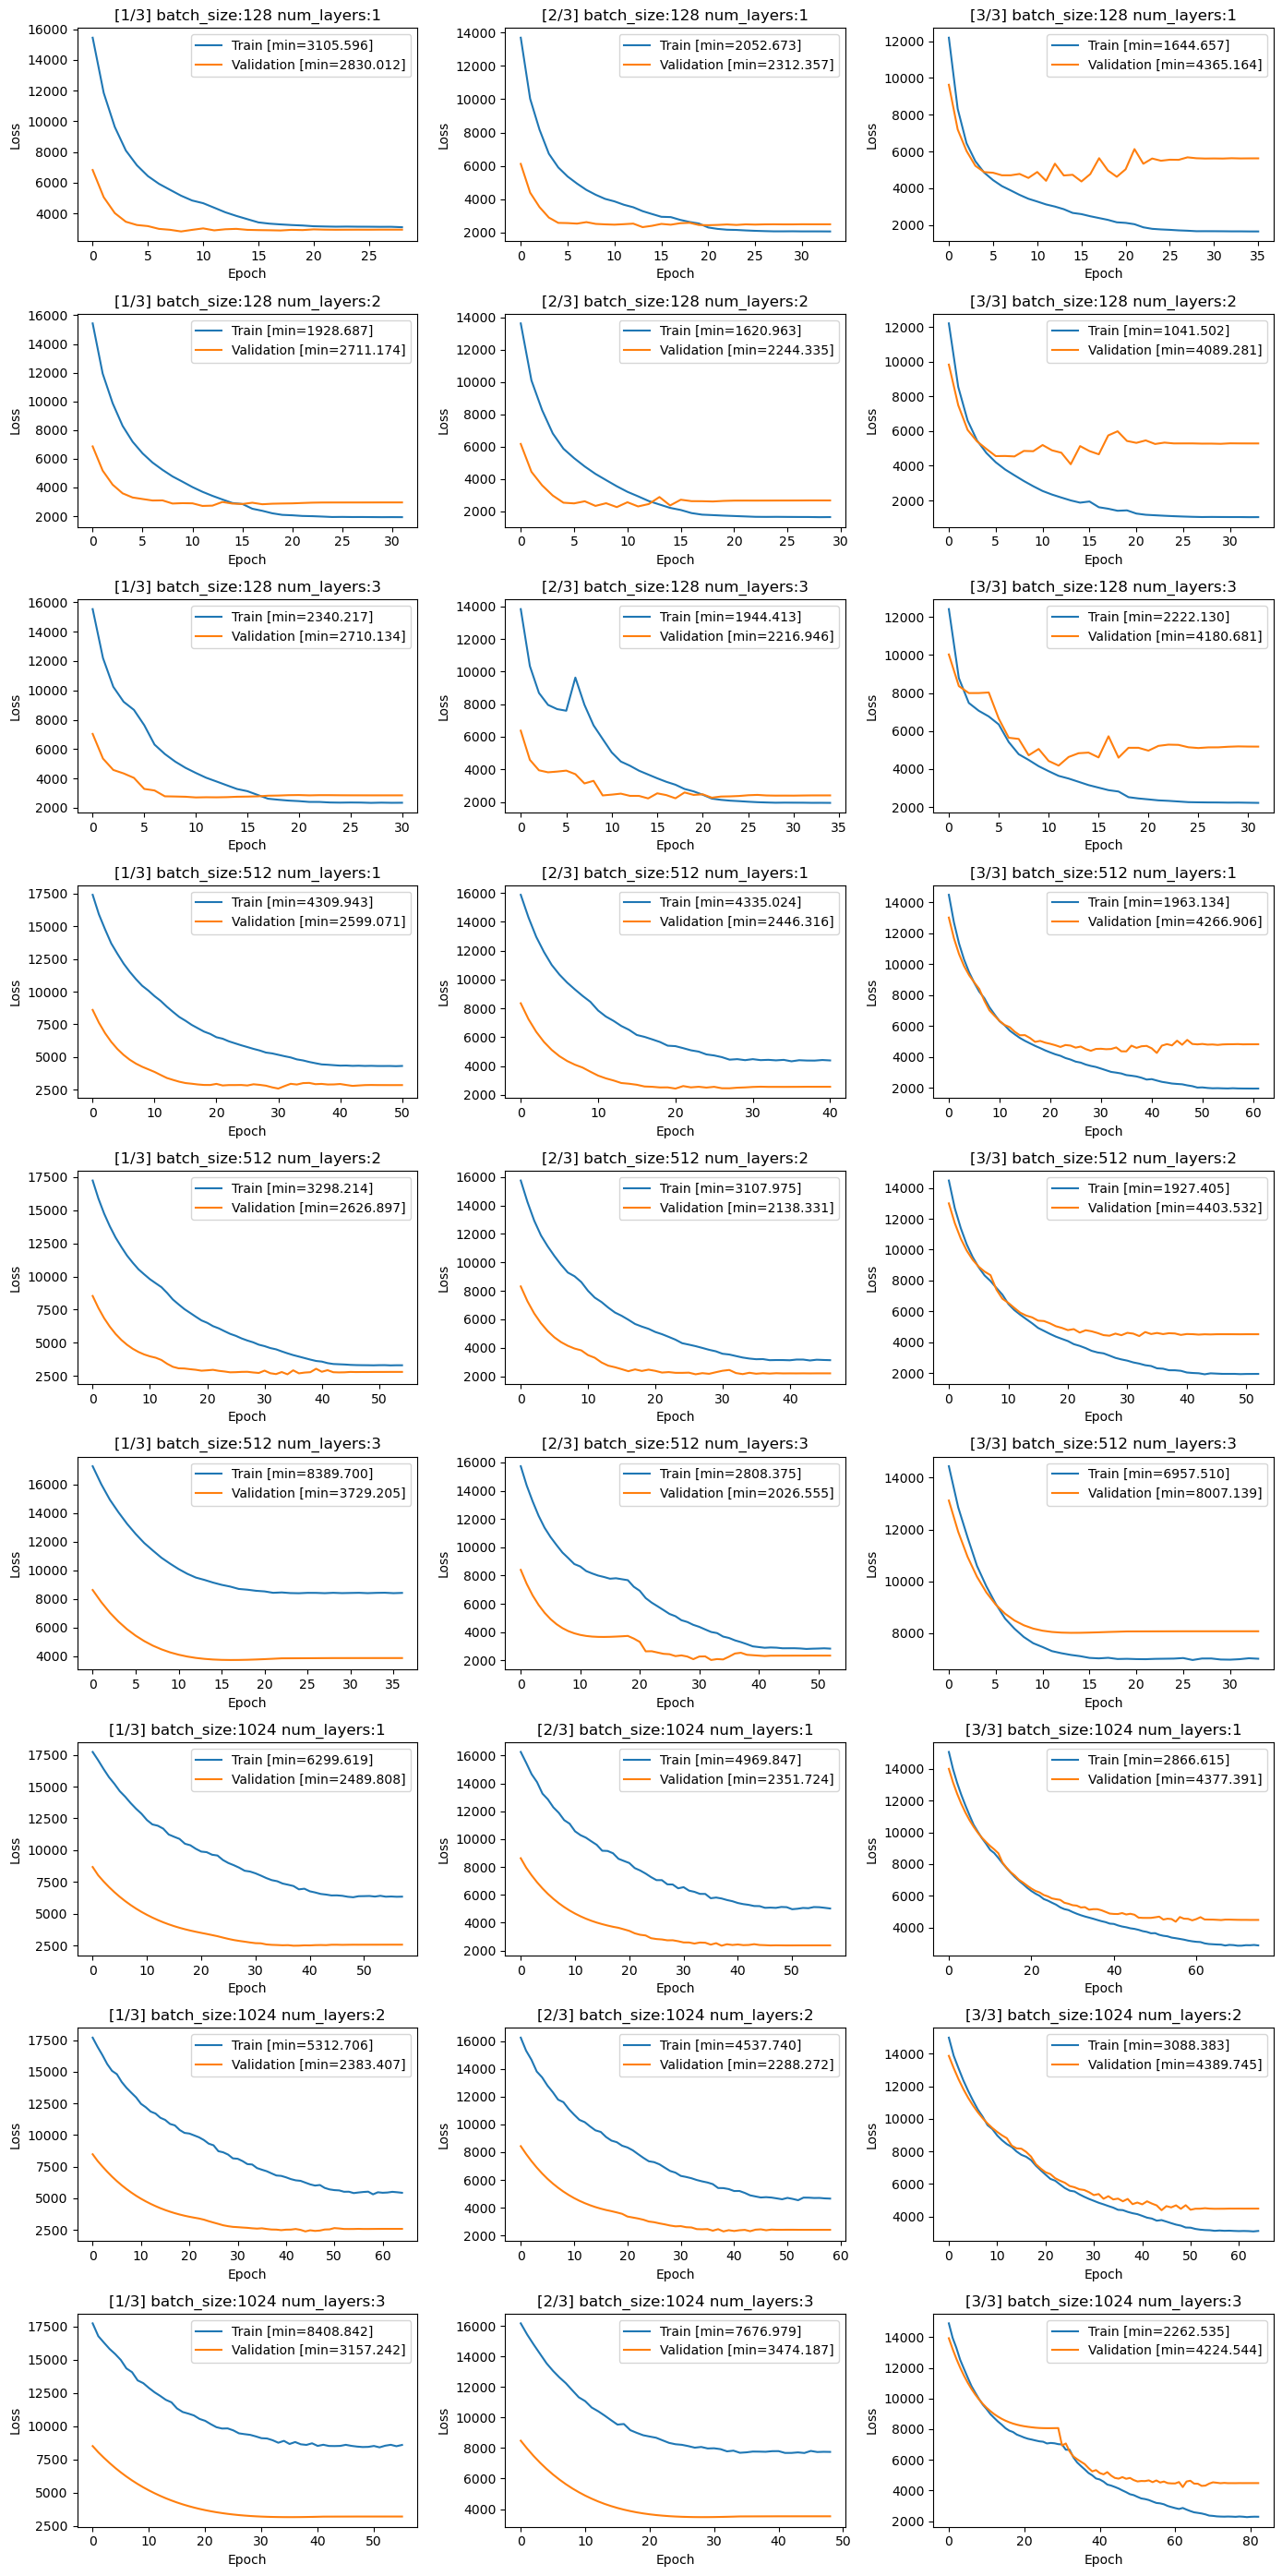

In [36]:
plt.figure(figsize=[14,28])
i = 1

for bs in sorted(list(set(df_list['batch_size']))): # sortedでソート（組み込み関数）、setは重複を除去
    for nl in sorted(list(set(df_list['num_layers']))):
        df = df_list[(df_list['batch_size'] == bs) & (df_list['num_layers'] == nl)]

        for j in range(3):  # time-series-splitの分割数
            plt.subplot(9,3,i+j)
            loss_train = df.iloc[j]['loss_train']
            loss_val = df.iloc[j]['loss_val']
            plt.plot(range(len(loss_train)), loss_train, label='Train [min={:7.3f}]'.format(min(loss_train)))
            plt.plot(range(len(loss_val)), loss_val, label='Validation [min={:7.3f}]'.format(min(loss_val)))
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('[{}/3] batch_size:{} num_layers:{}'.format(j+1, bs, nl))
            plt.legend()
        i += 3
plt.tight_layout()

奇妙なことに検証データの方がLossが低い事が多い  
右側列は訓練データが最も多いからか，理想通りのLossの推移をしている  
バッチサイズが小さい場合も，理想に近いLossの推移をすることが多い（イテレーション数が多い，局所解に陥りにくいから？）

また，いずれも100エポックに達する前にLossが収束して早期終了した

#### 評価指標で比較

groupbyで集約

In [37]:
df_eval = df_list.copy()
df_eval.drop(['loss_train', 'loss_val'], axis=1, inplace=True)
df_eval = df_eval.groupby(['batch_size', 'num_layers']).mean()
df_eval

r2_train  mae_train  rmse_train    r2_val    mae_val  \
batch_size num_layers                                                         
128        1           0.706516  28.993020   47.247560  0.336733  43.183482   
           2           0.801908  21.278514   38.830983  0.339436  41.967687   
           3           0.714875  28.237916   46.555920  0.368539  41.853574   
512        1           0.541249  34.309143   58.753773  0.359620  42.269849   
           2           0.637447  27.161449   52.533088  0.374073  41.279045   
           3           0.205287  52.404595   76.203409  0.120122  54.466476   
1024       1           0.386522  39.956245   68.172453  0.348405  42.343180   
           2           0.429430  36.280059   65.939146  0.353726  41.499607   
           3           0.210253  51.085070   76.031491  0.143668  50.839959   

                        rmse_val  
batch_size num_layers             
128        1           59.649935  
           2           59.224011  
           3           58.079995  
512        1           58.199447  
           2           57.441831  
           3           68.856238  
1024       1           58.410153  
           2           58.185420  
           3           65.582237

3つの指標で一番いいモデルを抽出

In [38]:
df_eval[(df_eval['r2_val'] == df_eval['r2_val'].max()) | (df_eval['mae_val'] == df_eval['mae_val'].min()) | (df_eval['rmse_val'] == df_eval['rmse_val'].min())]

,,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
batch_size,num_layers,,,,,,
512,2,0.637447,27.161449,52.533088,0.374073,41.279045,57.441831


2つのモデルが候補として出てきた  
テストデータで評価を行ってみる

### モデル評価

選ばれたパラメータで再度モデルを学習して評価を行う  

本当は行わないが分析用にテストデータに対するロスも監視してみる

In [39]:
def train_analysis(model, train_loader, val_loader, test_loader, verbose=False):
    # LSTMのハイパーパラメータ（本当はチューニングを行う）
    learning_rate = 0.01
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=1e-5, factor=0.1)   # ロスの値を監視しながら学習率減衰
    epoch = 300     # 最適なepoch数を決めるのではなく、ロスを監視しながら設定数に達する前に学習を打ち切るのが正しい

    earlystopping = EarlyStopping(patience=20, verbose=False)

    device = get_device()
    model.to(device)    # cudaを使いたい場合、この処理によってデータをGPUに送ることができる

    loss_train = []
    loss_val = []
    loss_test = []
    for e in range(epoch):
        # モデル学習
        model.train()   # 学習モード。ドロップアウト層など学習と推論で動作が異なる部分を操作
        loss_epc_train = 0.0
        for btc_idx, (data, target) in enumerate(train_loader): # ミニバッチ学習
            optimizer.zero_grad()                               # 勾配を初期化
            data, target = data.to(device), target.to(device)
            pred_target = model(data)                           # 推論。これは親クラスの__call__()でLSTMのforward()を呼び出している
            pred_target = pred_target.squeeze()                 # 一元化
            loss_bth = criterion(pred_target, target)           # ロス計算（今はMSE）
            loss_bth.backward()                                 # 逆伝播、勾配計算
            optimizer.step()                                    # 重みの更新
            loss_epc_train += loss_bth.item()
        loss_epc_train /= (btc_idx+1)
        loss_train.append(loss_epc_train)

        # モデル検証
        model.eval()    # 推論モード。検証データでロスの減少を監視
        loss_epc_val = 0.0
        for btc_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            pred_target = model(data)
            pred_target = pred_target.squeeze()
            loss_bth = criterion(pred_target, target)
            loss_epc_val += loss_bth.item()
        loss_epc_val /= (btc_idx+1)
        loss_val.append(loss_epc_val)

        ''' 追加 '''
        # テストデータ
        model.eval()
        loss_epc_test = 0.0
        for btc_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            pred_target = model(data)
            pred_target = pred_target.squeeze()
            loss_bth = criterion(pred_target, target)
            loss_epc_test += loss_bth.item()
        loss_epc_test /= (btc_idx+1)
        loss_test.append(loss_epc_test)
        ''' 追加 '''

        scheduler.step(loss_epc_val)    # 検証データのロスを渡す

        if verbose:
            tqdm.write('[Epoch {:0>3}] Train loss:{:>10.3f} | Validation loss:{:>10.3f}| Test loss:{:>10.3f}  | learning_rate:{:>10.7f}'\
                .format(e, loss_epc_train, loss_epc_val, loss_epc_test, optimizer.param_groups[0]['lr']))

        earlystopping(loss_epc_val, model)
        if earlystopping.early_stop:    # 早期終了するか確認
            if verbose:
                tqdm.write('Early Stopping!')
            break
    
    model.load_state_dict(earlystopping.get_best_params())  # 最もロスが少ないモデルパラメータを読み込み
    return model, loss_train, loss_val, loss_test


In [40]:
target_name = 'PM25'
lookback = 12
result_list = []

best_params = [{'batch_size':128, 'num_layers':1}, {'batch_size':1024, 'num_layers':2}]

train_data, test_data = data.loc[:'2014-12-31'].copy(), data.loc['2015-01-01':].copy()   # 訓練・検証/テスト
train_data, test_data = preprocessing_ts(train_data, test_data)   # 前処理

X_train, y_train = train_data.drop(target_name, axis=1), train_data[target_name]    # X, y分割
X_test, y_test = test_data.drop(target_name, axis=1), test_data[target_name]

X_train, y_train = make_subsequence(X_train, lookback), make_subsequence(y_train, lookback) # サブシーケンスデータの作成
X_test, y_test = make_subsequence(X_test, lookback), make_subsequence(y_test, lookback)
y_train, y_test = np.array([y[-1] for y in y_train]), np.array([y[-1] for y in y_test])   # yはサブシーケンスじゃなくて時点（make_subsequence()する必要はない）

train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))   # X, yを1つのタプルとして出力するイテレータ
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

for p in tqdm(best_params):   # パラメータのイテレート
    fix_seed(0)
    train_loader_sfl = DataLoader(train_set, batch_size=p['batch_size'], shuffle=True, drop_last=True, num_workers=os.cpu_count())  # ミニバッチの作成、学習用
    train_loader = DataLoader(train_set, batch_size=p['batch_size'], shuffle=False, drop_last=False, num_workers=os.cpu_count())    # バッチサイズはどうでもいい
    test_loader = DataLoader(test_set, batch_size=p['batch_size'], shuffle=False, drop_last=False, num_workers=os.cpu_count())      # バッチサイズはどうでもいい
    
    model = LSTM(input_size=X_train.shape[-1], num_layers=p['num_layers'])
    model, loss_train, loss_val, loss_test = train_analysis(model, train_loader_sfl, train_loader, test_loader, verbose=True)  # 検証データがないので訓練データを入れる（間違った考えかも？）
    pred_train = predict(model, train_loader)   # 訓練データ推論
    pred_test = predict(model, test_loader)   # テストデータ推論

    df_res = pd.DataFrame(data=p.values(), index=p.keys()).T
    df_res[['r2_train', 'mae_train', 'rmse_train']] = get_score(y_train, pred_train)
    df_res[['r2_test', 'mae_test', 'rmse_test']] = get_score(y_test, pred_test)
    df_res['loss_train'] = [loss_train]
    df_res['loss_val'] = [loss_val]
    df_res['loss_test'] = [loss_test]
    df_res['parameters'] = [model.state_dict()] # モデルパラメータの保存
    result_list.append(df_res)
df_result = pd.concat(result_list, axis=0)
pd.to_pickle(df_result, './result/lstm_eval.pkl')

  0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 000] Train loss: 11818.301 | Validation loss:  9276.488| Test loss: 11039.578  | learning_rate: 0.0100000
[Epoch 001] Train loss:  7948.460 | Validation loss:  6755.349| Test loss:  8520.158  | learning_rate: 0.0100000
[Epoch 002] Train loss:  6099.415 | Validation loss:  5495.359| Test loss:  7201.342  | learning_rate: 0.0100000
[Epoch 003] Train loss:  5126.554 | Validation loss:  4800.649| Test loss:  6517.675  | learning_rate: 0.0100000
[Epoch 004] Train loss:  4600.367 | Validation loss:  4402.200| Test loss:  6145.672  | learning_rate: 0.0100000
[Epoch 005] Train loss:  4255.961 | Validation loss:  4062.812| Test loss:  5835.723  | learning_rate: 0.0100000
[Epoch 006] Train loss:  3945.918 | Validation loss:  3736.930| Test loss:  5433.962  | learning_rate: 0.0100000
[Epoch 007] Train loss:  3657.337 | Validation loss:  3508.943| Test loss:  5367.688  | learning_rate: 0.0100000
[Epoch 008] Train loss:  3471.241 | Validation loss:  3414.438| Test loss:  5361.100  | learning

最大エポック数を300にしていたが収束しきる前に300に達してしまった．本当はさらに学習を進める必要がある  
ただしこれは学習（・検証）データを使ってValidaiton Lossを出しているため，学習しすぎても過学習する恐れがある  
学習データと検証データを混ぜずに，学習モデルの評価を行った方が実はいいモデルができるかもしれない

（参考）  
実行時間は以下  
CPU：145分  
GPU：92分

### 結果・考察

In [41]:
df_result = pd.read_pickle('./result/lstm_eval.pkl')
df_result.head()

,batch_size,num_layers,r2_train,mae_train,rmse_train,r2_test,mae_test,rmse_test,loss_train,loss_val,loss_test,parameters
0,128,1,0.944538,14.073575,19.924312,0.365205,49.301883,75.687487,"[11818.301199776786, 7948.460030691965, 6099.4...","[9276.487947834072, 6755.349116197273, 5495.35...","[11039.578206380209, 8520.158222273285, 7201.3...","{'lstm.weight_ih_l0': [[tensor(-0.8743, device..."
0,1024,2,0.958422,8.087066,17.251123,0.415275,48.392218,72.641226,"[14767.276489257812, 13736.692138671875, 12793...","[14033.422162224264, 13100.16814108456, 12263....","[19165.271623883928, 18176.827776227678, 17286...","{'lstm.weight_ih_l0': [[tensor(0.5750, device=..."


Random Forestと比べても精度が低く過学習してる？

#### モデルパラメータの読み込み

保存したモデルパラメータを読み込んで再度推論を行う  
Pytorchではモデル本体を保存するのではなく，モデルパラメータをdict形式で保存・読み込みするのが基本  

あくまでパラメータだけなので読み込む際にモデルクラスのインスタンスの生成が必要になる  
ちょっと躓くのが保存時にCPUにあったかGPUにあったかで，読み込み先もが変わる  
モデルがGPUにあるときに保存した場合はモデルをGPUに移動した上で読み込む，または引数（map_location）でGPUを指定する必要がある

In [42]:
lstm_128 = LSTM(14, 1).to(get_device())     # インスタンス生成（当然だが入力サイズや層の数とかも同じでないとエラー）
lstm_1024 = LSTM(14, 2).to(get_device())    # GPU上でパラメータ保存したのでモデルをGPUに移動
lstm_128.load_state_dict(df_result[df_result['batch_size'] == 128]['parameters'][0])
lstm_1024.load_state_dict(df_result[df_result['batch_size'] == 1024]['parameters'][0])

<All keys matched successfully>

In [43]:
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False, num_workers=os.cpu_count()) # バッチサイズはどうでもいい

pred_128 = predict(lstm_128, test_loader)
pred_1024 = predict(lstm_1024, test_loader)

#### Lossの推移を確認

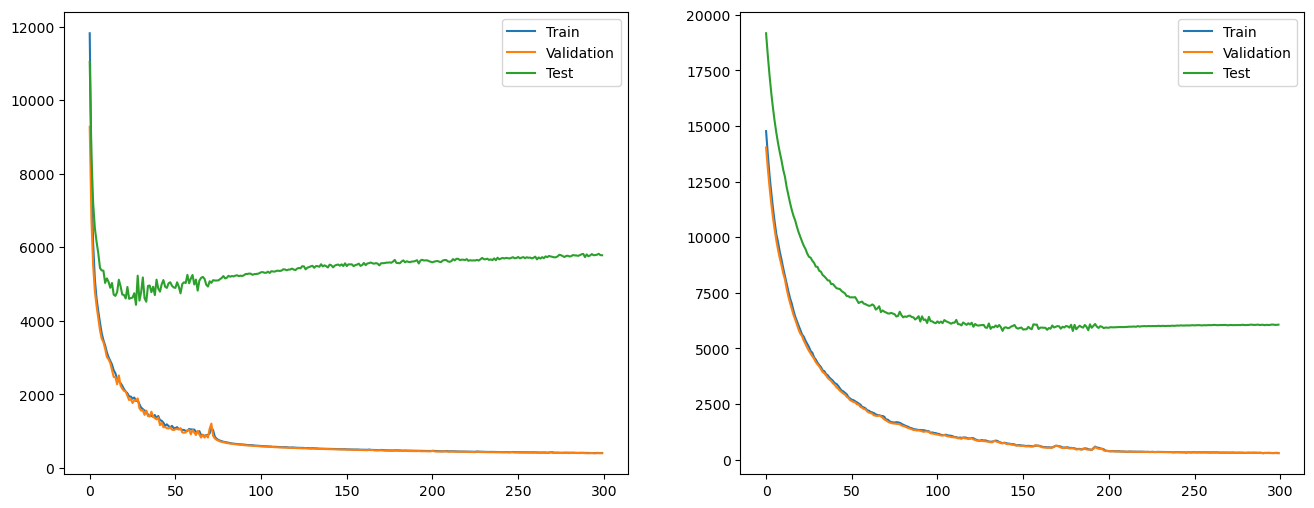

In [44]:
plt.figure(figsize=[16,6])
for i in range(2):
    plt.subplot(1,2,i+1)
    tmp = df_result.iloc[i]
    plt.plot(range(len(tmp['loss_train'])), tmp['loss_train'], label='Train')
    plt.plot(range(len(tmp['loss_val'])), tmp['loss_val'], label='Validation')
    plt.plot(range(len(tmp['loss_test'])), tmp['loss_test'], label='Test')
    plt.legend()

TrainとValidationは同じデータセットから作成しているためほとんど同じ推移になっていることは気にしなくてよい  
予想だが，学習を進めることによってちゃんとLossが収束しており発散しているわけではないため過学習ではなさそう

#### 真値と推定値を散布図で比較

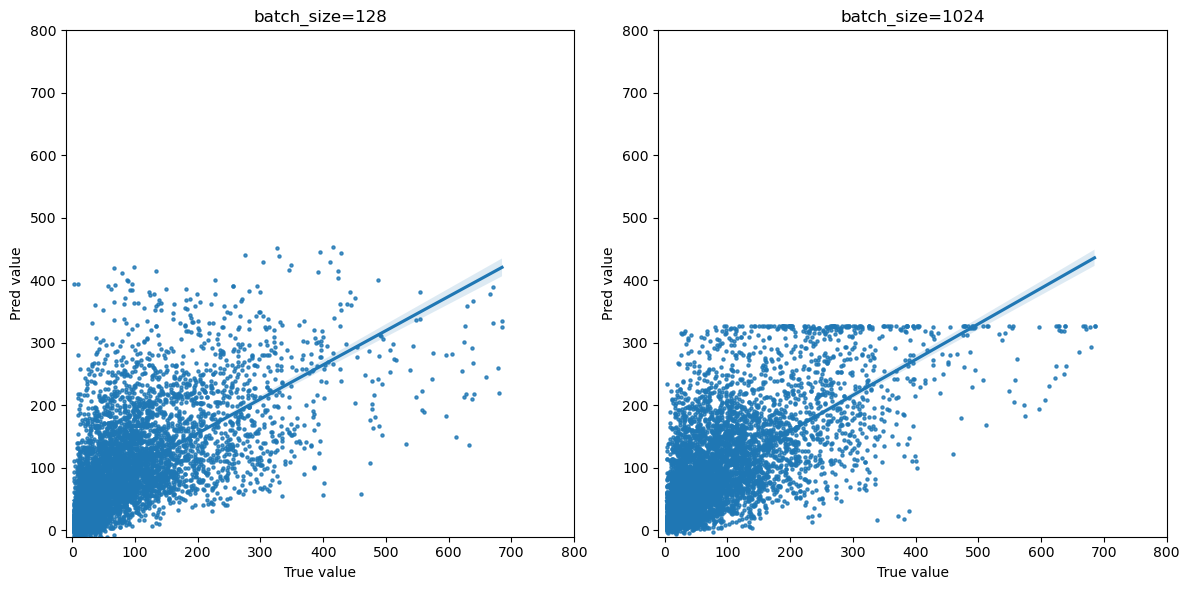

In [45]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.regplot(x=y_test, y=pred_128, scatter_kws={'s':5})
plt.xlim(-10, 800)
plt.ylim(-10, 800)
plt.xlabel('True value')
plt.ylabel('Pred value')
plt.title('batch_size=128')

plt.subplot(1,2,2)
sns.regplot(x=y_test, y=pred_1024, scatter_kws={'s':5})
plt.xlim(-10, 800)
plt.ylim(-10, 800)
plt.xlabel('True value')
plt.ylabel('Pred value')
plt.title('batch_size=1024')
plt.tight_layout()

batch_size=512の方は400，batch_size=1024の方は300くらいに予測値の壁がある  
500~700くらいの少数データを予測できていない  

#### 真値と推定値を推移可視化で比較

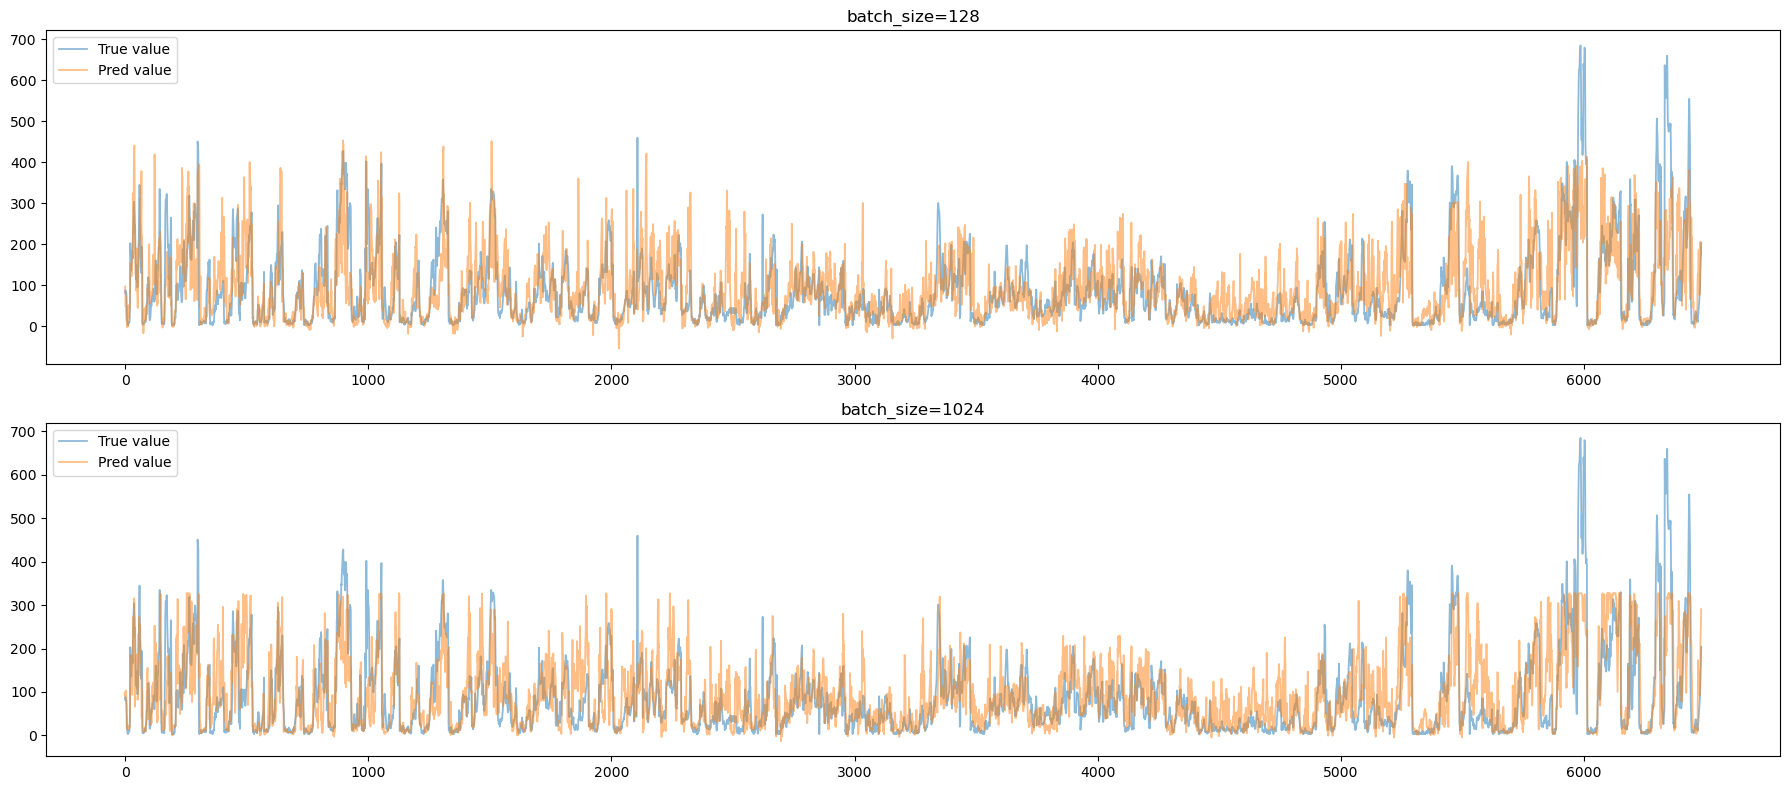

In [46]:
plt.figure(figsize=[18,8])
plt.subplot(2,1,1)
plt.plot(range(len(y_test)), y_test, label='True value', alpha=0.5, linewidth=1.3)
plt.plot(range(len(pred_128)), pred_128, label='Pred value', alpha=0.5, linewidth=1.3)
plt.legend()
plt.title('batch_size=128')

plt.subplot(2,1,2)
plt.plot(range(len(y_test)), y_test, label='True value', alpha=0.5, linewidth=1.3)
plt.plot(range(len(pred_1024)), pred_1024, label='Pred value', alpha=0.5, linewidth=1.3)
plt.title('batch_size=1024')
plt.legend()
plt.tight_layout()

上下の変動自体はある程度予測できていそうだが，値の誤差は大きめ  
後半の500~700ゾーンは予測できてない

#### 推定誤差の分布を可視化

Text(0.5, 1.0, 'batch_size=1024')

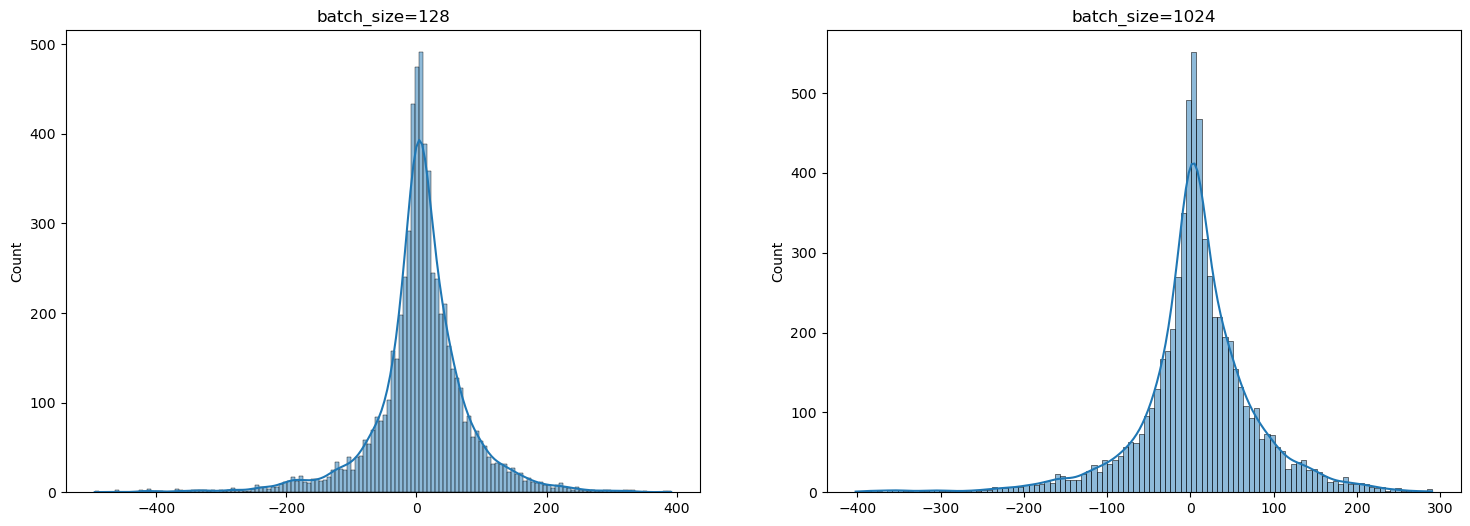

In [47]:
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
sns.histplot(x=pred_128-y_test, kde=True)
plt.title('batch_size=128')
plt.subplot(1,2,2)
sns.histplot(x=pred_1024-y_test, kde=True)
plt.title('batch_size=1024')

高バリアンスによる誤差がみられる  
つまり，訓練データとテストデータの分布間に差はなさそう

#### 訓練データとテストデータの分布を比較

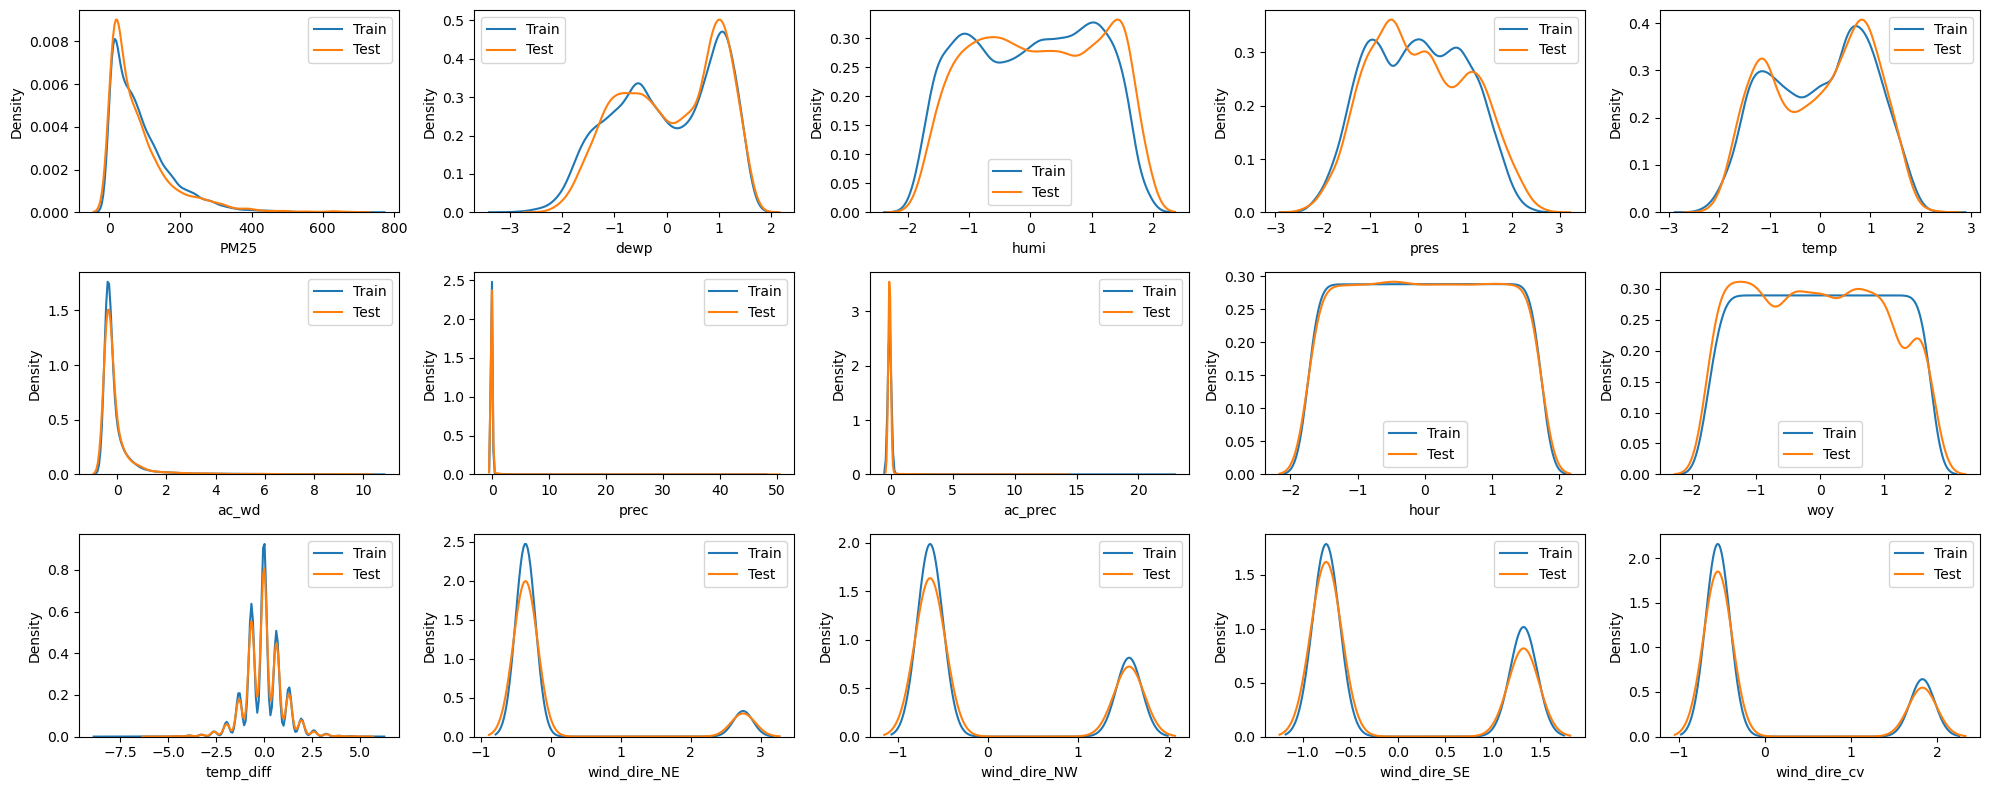

In [48]:
plt.figure(figsize=[20,8])
for i, c in enumerate(train_data.columns):
    plt.subplot(3,5,i+1)
    sns.kdeplot(data=train_data, x=c, label='Train')
    sns.kdeplot(data=test_data, x=c, label='Test')
    plt.legend()
plt.tight_layout()

訓練データとテストデータの分布間にほとんど差はなさそうだ  
これはあくまで単変量での分析なので，多変量で見た場合の分布はこれではわからない

## 結論

LSTMのような時系列に強い複雑なモデルを使うよりRandom Forestを使った方が精度が出た  
そもそも環境データとPM2.5は相関があまりなかったので，環境データから予測するのは難しそう  
RMSEがMAEより高い，大きな誤差が多いため，不均衡是正策は効くかもしれない（損失関数の変更、サンプリング等）

## おわりに

データを提供されたところから実際に機械学習で予測するところまでの一連の流れをやってみた  
当然だがこれはあくまで一例，思い付きで処理をしているだけなので各ステップで色々と考察すべきところがある  

時系列データは関係ないが，基本的にはここでやったようにウォーターフォール型で各ステップをこなしていくため，後戻りが面倒  
そのため、自分一人の考えで全てを進めていくのではなく，都度誰かに相談したり，進捗内容を関係者に共有したりしながら無駄のないように進めていくのが大事  
（といっても基本的に自分一人）  

何か研究テーマのヒントにでもなってれば幸いです